In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import resample
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.optimizers import Adam
import pickle

In [2]:
# Initializing the path of the working directory
base_dir = r"C:\Users\MSI\Documents\MiniProject"

# Mapping the image id with their path so that it can be referred easily
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x 
                     for x in glob(os.path.join(base_dir, 'sample', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


In [3]:
# Reffering to the medadata having the information about all the images we have.
skin_df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))

# Creating New Columns path , cell_type and cell_type_idx for better readability

# Keeping the path of the respected image
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)

# Keeping the human understable Name with the respected name
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)

# Keeping the index of the cell_type of the dict
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [4]:
skin_df['cell_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [5]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,C:\Users\MSI\Documents\MiniProject\sample\ISIC...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,C:\Users\MSI\Documents\MiniProject\sample\ISIC...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,C:\Users\MSI\Documents\MiniProject\sample\ISIC...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,C:\Users\MSI\Documents\MiniProject\sample\ISIC...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,C:\Users\MSI\Documents\MiniProject\sample\ISIC...,Benign keratosis-like lesions,2


In [6]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
dataset           0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [7]:
skin_df['age'].fillna((skin_df['age'].mean()) , inplace = True)

In [8]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
dataset          0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [9]:
cell_type_idx = 'cell_type_idx'
record_0 = skin_df[skin_df[cell_type_idx] == 0]
record_1 = skin_df[skin_df[cell_type_idx] == 1]
record_2 = skin_df[skin_df[cell_type_idx] == 2]
record_3 = skin_df[skin_df[cell_type_idx] == 3]
record_4 = skin_df[skin_df[cell_type_idx] == 4]
record_5 = skin_df[skin_df[cell_type_idx] == 5]
record_6 = skin_df[skin_df[cell_type_idx] == 6]

In [10]:
n = 500
record_bal_0 = resample(record_0 , replace = True , n_samples = n , random_state = 42)
record_bal_1 = resample(record_1 , replace = True , n_samples = n , random_state = 42)
record_bal_2 = resample(record_2 , replace = True , n_samples = n , random_state = 42)
record_bal_3 = resample(record_3 , replace = True , n_samples = n , random_state = 42)
record_bal_4 = resample(record_4 , replace = True , n_samples = n , random_state = 42)
record_bal_5 = resample(record_5 , replace = True , n_samples = n , random_state = 42)
record_bal_6 = resample(record_6 , replace = True , n_samples = n , random_state = 42)

In [11]:
balance_record = pd.concat([record_bal_0 , record_bal_1 , record_bal_2 , record_bal_3 , record_bal_4 , record_bal_5 , record_bal_6])

In [12]:
balance_record['image'] = balance_record['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))

In [13]:
X = np.asarray(balance_record['image'].tolist())

In [14]:
Y = balance_record['cell_type_idx']

In [15]:
Y_cat = to_categorical(Y)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.20,random_state=42)

In [17]:
x_train_mean = np.mean(x_train)
x_test_mean = np.mean(x_test)

x_train_std = np.std(x_train)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std

In [18]:
input_shape = (64 , 64 , 3)

model = Sequential()
model.add(Conv2D(256, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3),activation='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 128)       0

In [19]:
model.compile(optimizer='adam' , loss='categorical_crossentropy' , metrics=['accuracy'])

In [23]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [ ]:
epochs = 50
batch_size = 16
history = model.fit(datagen.flow(x_train , y_train  , batch_size = batch_size) , epochs = epochs , validation_data=(x_test , y_test) , verbose = 1)

Epoch 1/50
175/175 [==============================] - 72s 405ms/step - loss: 1.7801 - accuracy: 0.2871 - val_loss: 1.5501 - val_accuracy: 0.3843
Epoch 2/50
175/175 [==============================] - 70s 397ms/step - loss: 1.5851 - accuracy: 0.3818 - val_loss: 1.4931 - val_accuracy: 0.4100
Epoch 3/50
175/175 [==============================] - 74s 425ms/step - loss: 1.4536 - accuracy: 0.4179 - val_loss: 1.4054 - val_accuracy: 0.4543
Epoch 4/50
175/175 [==============================] - 70s 402ms/step - loss: 1.3835 - accuracy: 0.4568 - val_loss: 1.3147 - val_accuracy: 0.5043
Epoch 5/50
175/175 [==============================] - 72s 413ms/step - loss: 1.2999 - accuracy: 0.4775 - val_loss: 1.2684 - val_accuracy: 0.4729
Epoch 6/50
175/175 [==============================] - 69s 395ms/step - loss: 1.2414 - accuracy: 0.5068 - val_loss: 1.1631 - val_accuracy: 0.5686
Epoch 7/50
175/175 [==============================] - 70s 400ms/step - loss: 1.1970 - accuracy: 0.5336 - val_loss: 1.2004 - val_ac

In [22]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("cnn2.h5")

22/22 [==============================] - 5s 216ms/step - loss: 1.3236 - accuracy: 0.8286
Test: accuracy = 0.828571  ;  loss = 1.323605


In [23]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1, len(model_history.history['accuracy'])/10))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
   #  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1, len(model_history.history['loss'])/10))

    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

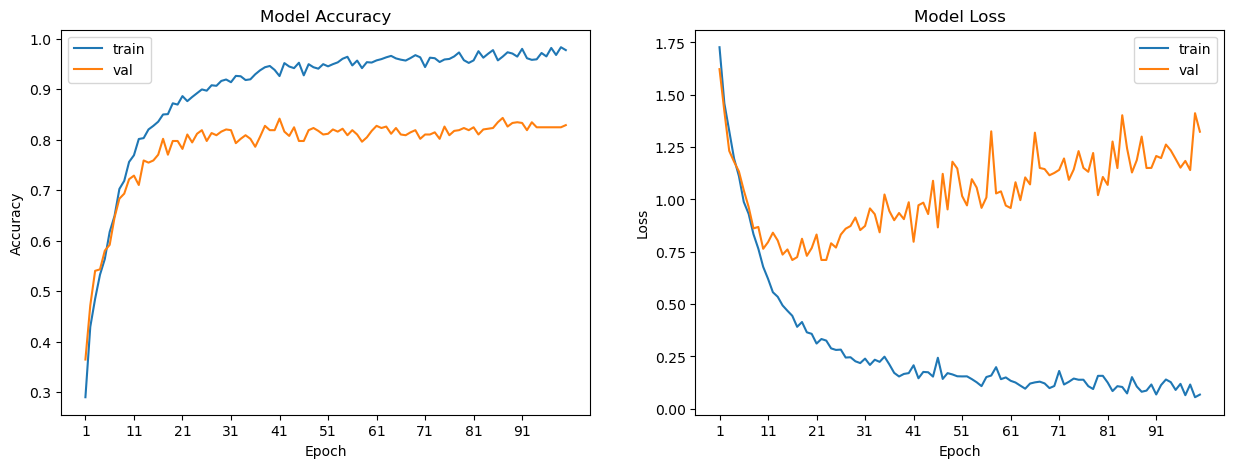

In [24]:
plot_model_history(history)

In [25]:
prediction = model.predict(x_test)

22/22 [==============================] - 5s 227ms/step


In [26]:
y_predict_classes = np.argmax(prediction , axis=1)

In [27]:
y_predict_classes

array([3, 4, 4, 3, 0, 5, 3, 3, 5, 0, 3, 5, 6, 5, 1, 4, 1, 0, 6, 5, 0, 3,
       5, 3, 2, 5, 1, 1, 3, 6, 6, 3, 5, 1, 6, 6, 0, 0, 1, 4, 3, 6, 1, 4,
       4, 0, 3, 3, 1, 2, 0, 4, 5, 6, 2, 0, 5, 0, 4, 3, 6, 5, 1, 0, 3, 6,
       0, 3, 5, 5, 2, 1, 2, 2, 1, 4, 6, 5, 6, 3, 6, 6, 6, 6, 5, 5, 2, 0,
       1, 0, 2, 6, 1, 5, 6, 5, 0, 5, 3, 1, 0, 4, 2, 2, 2, 0, 6, 6, 1, 0,
       0, 1, 0, 2, 4, 1, 6, 2, 2, 3, 1, 2, 6, 2, 1, 1, 4, 3, 1, 0, 3, 0,
       0, 6, 5, 4, 6, 6, 1, 3, 2, 6, 4, 3, 5, 5, 5, 1, 4, 0, 0, 4, 4, 1,
       5, 2, 0, 3, 5, 3, 5, 5, 4, 4, 2, 1, 2, 0, 4, 3, 3, 2, 0, 2, 3, 6,
       1, 5, 1, 6, 6, 2, 2, 0, 2, 2, 2, 3, 3, 5, 4, 5, 6, 2, 4, 6, 2, 3,
       2, 0, 2, 0, 3, 5, 0, 5, 5, 6, 6, 4, 4, 0, 6, 6, 6, 6, 2, 4, 0, 4,
       2, 1, 0, 1, 5, 3, 6, 2, 3, 3, 2, 3, 1, 6, 1, 3, 2, 3, 0, 1, 1, 0,
       1, 0, 3, 3, 4, 1, 6, 3, 2, 6, 3, 0, 1, 3, 1, 2, 1, 3, 2, 0, 5, 2,
       6, 4, 1, 4, 0, 1, 6, 3, 0, 1, 0, 0, 0, 6, 5, 3, 2, 3, 0, 6, 0, 1,
       0, 4, 1, 6, 5, 1, 3, 4, 4, 5, 5, 1, 2, 3, 0,

In [28]:
y_true = np.argmax(y_test , axis=1)

In [29]:
y_true

array([3, 4, 4, 3, 0, 4, 3, 3, 2, 0, 3, 5, 6, 1, 1, 1, 1, 2, 6, 5, 0, 3,
       0, 3, 2, 2, 1, 0, 3, 6, 6, 3, 4, 1, 6, 6, 0, 0, 1, 4, 3, 6, 1, 4,
       4, 0, 3, 3, 1, 0, 0, 0, 5, 6, 2, 0, 2, 0, 4, 3, 6, 2, 1, 0, 3, 6,
       0, 3, 1, 5, 5, 1, 0, 2, 1, 4, 6, 5, 6, 3, 6, 6, 6, 6, 5, 5, 2, 5,
       0, 0, 4, 6, 1, 5, 6, 5, 0, 2, 3, 1, 0, 4, 2, 2, 0, 0, 6, 6, 1, 0,
       0, 1, 2, 1, 4, 1, 6, 1, 5, 3, 1, 5, 6, 2, 1, 1, 4, 3, 1, 0, 3, 0,
       0, 6, 4, 4, 6, 6, 1, 0, 2, 6, 4, 3, 5, 5, 4, 1, 2, 0, 0, 4, 4, 1,
       5, 2, 0, 3, 0, 3, 5, 5, 0, 5, 2, 1, 2, 4, 4, 3, 3, 1, 0, 2, 3, 6,
       1, 5, 1, 6, 6, 2, 0, 0, 2, 1, 2, 3, 3, 5, 4, 5, 6, 2, 4, 6, 4, 3,
       2, 2, 2, 0, 3, 2, 0, 5, 5, 6, 6, 4, 4, 0, 6, 6, 6, 6, 2, 5, 5, 5,
       2, 1, 0, 1, 5, 3, 6, 2, 3, 3, 4, 3, 1, 6, 1, 3, 2, 3, 0, 1, 1, 0,
       1, 5, 3, 3, 4, 1, 6, 3, 2, 6, 3, 0, 1, 3, 5, 2, 1, 3, 2, 0, 0, 5,
       6, 4, 1, 4, 0, 0, 6, 1, 0, 1, 0, 0, 0, 6, 5, 3, 2, 3, 0, 6, 0, 1,
       0, 4, 1, 6, 5, 1, 0, 0, 4, 5, 5, 1, 0, 3, 0,